### Tugas Kapita Selekta Sistem Cerdas: Natural Language Processing
# Klasifikasi Teks dengan Naive Bayes Classification
Almas Fauzia Wibawa<br>
17/409427/PA/17734

## 1. Inisiasi Fungsi
Sebelum melakukan import data dan eksekusi program klasifikasi, tentunya, dibangun terlebih dahulu fungsi-fungsi yang dibutuhkan dalam membuat model klasifikasi dengan Naive Bayes Classification.
### a) Objek Model
Pertama-tama, dibuat sebuah objek model yang akan menyimpan 2 parameter Naive Bayes Classifier hasil estimasi dari proses training. Hal ini dilakukan juga agar hasil estimasi dari proses training dapat lebih mudah digunakan ketika akan memprediksi label di proses testing.

In [1]:
class Model:
    def __init__(self, prob_c0, prob_c1, prob_w_c0, prob_w_c1):
        self.prob_c0 = prob_c0
        self.prob_c1 = prob_c1
        self.prob_w_c0 = prob_w_c0
        self.prob_w_c1 = prob_w_c1

### b) Fungsi Pembuatan Vocabulary
Hal yang pertama kali dilakukan dalam proses training pada metode klasifikasi Multinomial Naive Bayes adalah membangun vocabulary. Fungsi pembuatan vocabulary ini akan menerima argumen berupa kumpulan dokumen yang dijadikan training data dan banyak kata yang ingin dibuat di dalam vocabulary. Akan diambil n kata dengan frekuensi terbesar di training data untuk dimasukkan ke vocabulary.

In [2]:
# membuat vocabulary

def make_vocab(x_train, n):
    # x_train merupakan list dokumen yang dijadikan training data
    # n merupakan banyak kata yang ingin ada di dalam vocabulary
    
    # menghitung frekuensi setiap kata
    from nltk.tokenize import word_tokenize
    
    titles = x_train
    freq = {}
    for t in titles:
        tokens = word_tokenize(t)
        for w in tokens:
            if w in freq:
                freq[w] += 1
            else:
                freq[w] = 1
    
    # mengurutkan kata berdasarkan frekuensinya
    sorted_freq = {key: values for key, values in sorted(freq.items(), key=lambda e: e[1], reverse=True)}
    
    # mengambil n kata dengan frekuensi terbesar untuk dijadikan vocabulary
    vocab = list(sorted_freq)[:1000]
    
    return vocab

### c) Fungsi Estimasi Parameter
Untuk membangun model Multinomial Naive Bayes, perlu dilakukan estimasi terhadap probabilitas prior dari setiap kelas dan probabilitas kondisional dari setiap kata terhadap setiap kelas. Estimasi probabilitas prior setiap kelas dapat ditemukan dengan membagi banyak dokumen yang termasuk dalam kelas tersebut dengan total dokumen yang ada di data training. Sedangkan, estimasi probabilitas kondisional setiap kata terhadap setiap kelas dapat ditemukan dengan membagi jumlah kemunculan kata tersebut di setiap kelas dengan jumlah kemunculan kata yang ada di kelas tersebut yang termasuk dalam vocabulary. Oleh karena itu, beberapa langkah yang perlu dilakukan adalah sebagai berikut:
1. Banyak dokumen yang masuk ke setiap kelas di data training
2. Banyak dokumen pada data training
3. Banyak kemunculan setiap kata di setiap kelas pada data training
4. Banyak kata yang muncul di setiap kelas yang termasuk dalam vocabulary

Karena dibutuhkan langkah yang cukup panjang untuk mengetahui beberapa hal tersebut (kecuali banyak dokumen pada data training), akan dibuat fungsi juga untuk melakukan penghitungannya.

#### Fungsi untuk menghitung banyak dokumen yang masuk ke setiap kelas di data training
Fungsi ini akan menerima masukan berupa kumpulan label yang dimiliki oleh training data.

In [3]:
# menghitung banyak dokumen yang masuk ke setiap kelas di data training

def nDocsEachClass(y_train):
    
    n_doc0 = list(y_train).count(0)
    n_doc1 = list(y_train).count(1)
    
    return n_doc0, n_doc1

#### Fungsi untuk menghitung kemunculan setiap kata di setiap kelas pada data training
Fungsi ini memiliki masukan berupa dokumen dan label dari training data.

In [4]:
# menghitung kemunculan setiap kata di setiap kelas pada data training

def nWordsEachClass(x_train, y_train):
    
    from nltk.tokenize import word_tokenize
    
    freq_0 = {}
    freq_1 = {}

    for i in range(len(x_train)):
        tokens = word_tokenize(x_train[i])

        # jika judul ke-i termasuk dalam kelas 0
        if y_train[i] == 0:
            for w in tokens:
                if w in freq_0:
                    freq_0[w] += 1
                else:
                    freq_0[w] = 1

        # jika judul ke-i termasuk dalam kelas 1
        else:
            for w in tokens:
                if w in freq_1:
                    freq_1[w] += 1
                else:
                    freq_1[w] = 1
    
    return freq_0, freq_1

#### Fungsi untuk menghitung banyak kata yang muncul di setiap kelas yang termasuk dalam vocabulary
Fungsi ini memiliki masukan berupa dictionary yang menyimpan banyak kemunculan setiap kata di kelas0, dictionary yang menyimpan banyak kemunculan setiap kata di kelas1, dan vocabulary.

In [5]:
# menghitung banyak kata yang muncul di setiap kelas yang termasuk dalam vocabulary

def nWordsEachClass_isInVocab(freq_0, freq_1, vocab):
    n_vocab0 = 0
    n_vocab1 = 0

    for w in vocab:
        # jika kata w muncul di kelas 0
        if w in freq_0:
            n_vocab0 += freq_0[w]

        # jika kata w muncul di kelas 1
        if w in freq_1:
            n_vocab1 += freq_1[w]
    
    return n_vocab0, n_vocab1

#### Melakukan estimasi
Tiga fungsi tadi kemudian dapat dipanggil untuk digunakan dalam melakukan estimasi. Terdapat 2 jenis fungsi estimasi, tanpa smoothing dan dengan smoothing.

Seperti yang sudah dituliskan sebelumnya, cara mengestimasi probabilitas prior dari setiap kelas adalah dengan membagi jumlah kemunculan kata tersebut di setiap kelas dengan jumlah kemunculan kata yang ada di kelas tersebut yang termasuk dalam vocabulary. Akan tetapi, jika cara tersebut dieksekusi, kata yang sama sekali tidak muncul di suatu kelas di data training akan memiliki probabilitas kemunculan di kelas tersebut dengan nilai 0. Hal ini tidak tepat untuk diaplikasikan di kasus nyata. Solusi dari permasalahan tersebut adalah dengan melakukan smoothing. Salah satu metode smoothing adalah Add-1 Smoothing, yaitu menambah setiap nilai frekuensi kata dengan angka 1. Dengan begitu, tidak akan ada kata yang memiliki probabilitas kemunculan 0 di kelas mana pun.

Akan dilihat perbandingan hasil antara estimasi tanpa smoothing dan dengan smoothing. Oleh karena itu, kedua jenis estimasi tersebut akan diimplementasikan fungsinya. Keduanya akan menerima masukan berupa dokumen dan label dari training data dan vocabulary yang telah dibangun diproses sebelumnya.

1. Estimasi tanpa smoothing

In [6]:
# estimasi tanpa smoothing

def estimateWithoutSmoothing(x_train, y_train, vocab):
    
    # menghitung banyak dokumen yang masuk ke setiap kelas di data training
    n_doc0, n_doc1 = nDocsEachClass(y_train)
    
    # menghitung banyak dokumen pada data training
    n_doc = len(x_train)
    
    # menghitung kemunculan setiap kata di setiap kelas pada data training
    freq_0, freq_1 = nWordsEachClass(x_train, y_train)
        
    # menghitung banyak kata yang muncul di setiap kelas yang termasuk dalam vocabulary
    n_vocab0, n_vocab1 = nWordsEachClass_isInVocab(freq_0, freq_1, vocab)
    
    # menghitung estimasi
    # probabilitas prior kelas 0
    prob_c0 = n_doc0/n_doc

    # probabilitas prior kelas 1
    prob_c1 = n_doc1/n_doc
    
    # probabilitas kondisional
    prob_w_c0 = {}
    prob_w_c1 = {}

    for w in vocab:
        # jika kata w muncul di kelas 0
        if w in freq_0:
            prob_w_c0[w] = freq_0[w] / n_vocab0
        else:
            prob_w_c0[w] =  0

        # jika kata w muncul di kelas 1
        if w in freq_1:
            prob_w_c1[w] = freq_1[w] / n_vocab1
        else:
            prob_w_c1[w] = 0
    
    return prob_c0, prob_c1, prob_w_c0, prob_w_c1

2. Estimasi dengan smoothing<br>
Metode smoothing yang digunakan disini adalah Add-1 Smoothing.

In [7]:
def estimateWithSmoothing(x_train, y_train, vocab):
    
    # menghitung banyak dokumen yang masuk ke setiap kelas di data training
    n_doc0, n_doc1 = nDocsEachClass(y_train)
    
    # menghitung banyak dokumen pada data training
    n_doc = len(x_train)
    
    # menghitung kemunculan setiap kata di setiap kelas pada data training
    freq_0, freq_1 = nWordsEachClass(x_train, y_train)
        
    # menghitung banyak kata yang muncul di setiap kelas yang termasuk dalam vocabulary
    n_vocab0, n_vocab1 = nWordsEachClass_isInVocab(freq_0, freq_1, vocab)
    
    # menghitung estimasi
    # probabilitas prior kelas 0
    prob_c0 = n_doc0/n_doc

    # probabilitas prior kelas 1
    prob_c1 = n_doc1/n_doc
    
    # probabilitas kondisional
    prob_w_c0 = {}
    prob_w_c1 = {}

    for w in vocab:
        # jika kata w muncul di kelas 0
        if w in freq_0:
            prob_w_c0[w] = (freq_0[w]+1)/(n_vocab0+len(vocab))
        else:
            prob_w_c0[w] = 1/(n_vocab0+len(vocab))

        # jika kata w muncul di kelas 1
        if w in freq_1:
            prob_w_c1[w] = (freq_1[w]+1)/(n_vocab1+len(vocab))
        else:
            prob_w_c1[w] = 1/(n_vocab1+len(vocab))
    
    return prob_c0, prob_c1, prob_w_c0, prob_w_c1

### d) Fungsi Training
Setelah diimplementasi fungsi untuk membuat vocabulary dan melakukan estimasi, dibangun fungsi training. Fungsi training akan menerima masukan berupa dokumen dan label dari training data, banyak vocabulary yang ingin dibangun, dan boolean apakah akan digunakan smoothing atau tidak. Fungsi ini akan memiliki luaran berupa model klasifikasi.

In [8]:
def training(x_train, y_train, nVocab, boolSmoothing):
    
    import pandas as pd
    
    # membuat vocab
    vocab = make_vocab(x_train, nVocab)
    
    # melakukan estimasi
    if boolSmoothing:
        prob_c0, prob_c1, prob_w_c0, prob_w_c1 = estimateWithSmoothing(x_train, y_train, vocab)
    else:
        prob_c0, prob_c1, prob_w_c0, prob_w_c1 = estimateWithoutSmoothing(x_train, y_train, vocab)
    
    model = Model(prob_c0, prob_c1, prob_w_c0, prob_w_c1)
    
    return model

### e) Fungsi Testing
Fungsi ini menerima masukan berupa testing data dan model yang telah dihasilkan dari fungsi training. Pemilihan kelas akan dilakukan dengan menggunakan Most Valuable Class. Yang dilakukan di fungsi ini adalah menghitung probabilitas setiap data merupakan anggota dari setiap kelas, dipilih kelas yang probabilitasnya paling tinggi, kemudian kelas tersebut lah yang menjadi label data tersebut. Probabilitas setiap data merupakan anggota dari setiap kelas dihitung dengan mengalikan probabilitas prior kelas tersebut dengan probabilitas kondisional setiap kata yang ada pada data terhadap kelas tersebut.

In [9]:
def testing(x_test, model):
    
    from nltk.tokenize import word_tokenize
    
    y = []

    for t in x_test:
        tokens = word_tokenize(t)
        # probabilitas prior
        p0 = model.prob_c0
        p1 = model.prob_c1

        # menghitung probabilitas title t masuk ke kelas 0 dan kelas 1
        for w in tokens:
            if w in model.prob_w_c0:
                p0 = p0 * model.prob_w_c0[w]

            if w in model.prob_w_c1:
                p1 = p1 * model.prob_w_c1[w]

        # penentuan most likely class
        if p0 > p1:
            y.append(0)
        else:
            y.append(1)

    return y

### f) Fungsi Evaluasi
Pada fungsi evaluasi, akan dilakukan pembentukan tabel kontingensi, perhitungan 4 metrik evaluasi (akurasi, presisi, recall, dan F1-measure), dan perhitungan rata-rata secara mikro dan makro. Beberapa langkah ini akan dipisahkan terlebih dahulu implementasinya di fungsi yang berbeda.<br>
#### Fungsi untuk membuat tabel kontingensi
Fungsi ini menerima masukan berupa label asli, label hasil prediksi, dan boolean apakah akan dilakukan pencetakan tabelnya. Pada fungsi ini, akan dihitung banyak label yang termasuk dalam True Positif, False Positive, False Negative, dan True Negative. Keempat angka tersebut nanti akan dijadikan luaran dari fungsi ini. Masing-masing kelas akan dihitung secara terpisah sehingga akan dihasilkan 1 tabel kontingensi untuk masing-masing kelas.

In [10]:
# membuat 2 tabel kontingensi untuk 2 kelas

def conf_matrix(y_real, y_predict, printMatrix):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    tp0 = 0
    fp0 = 0
    tn0 = 0
    fn0 = 0
    tp1 = 0
    fp1 = 0
    tn1 = 0
    fn1 = 0

    for i in range(len(y_real)):
        # true positive
        if (y_real[i] == 1) & (y_predict[i] == 1):
            tn0 += 1
            tp1 += 1

        # false positive
        elif (y_real[i] == 0) & (y_predict[i] == 1):
            fn0 += 1
            fp1 += 1

        # true negative
        elif (y_real[i] == 0) & (y_predict[i] == 0):
            tp0 += 1
            tn1 += 1

        # false negative
        elif (y_real[i] == 1) & (y_predict[i] == 0):
            fp0 += 1
            fn1 += 1
            
    if printMatrix:
        # kontingensi tabel untuk kelas 0
        plt.figure(figsize=(4,4))
        sns.heatmap([[tn0,fp0],[fn0,tp0]], annot=True, fmt='d', xticklabels=['false', 'true'],
                    yticklabels=['false', 'true'], cmap=plt.cm.Blues, cbar=False)
        plt.title("Class 0's Confusion Matrix")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # kontingensi tabel untuk kelas 1
        plt.figure(figsize=(4,4))
        sns.heatmap([[tn1,fp1],[fn1,tp1]], annot=True, fmt='d', xticklabels=['false', 'true'],
                    yticklabels=['false', 'true'], cmap=plt.cm.Blues, cbar=False)
        plt.title("Class 1's Confusion Matrix")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    
    return (tp0, fp0, tn0, fn0), (tp1, fp1, tn1, fn1)

#### Fungsi untuk menghitung 4 metrik evaluasi di setiap kelas
Fungsi ini menerima input berupa tupel tabel kontingensi yang dihasilkan di fungsi tabel kontingensi. Tupel tersebut berisi banyak label yang termasuk dalam True Positif, False Positive, False Negative, dan True Negative. Dari keempat angka tersebut, dilakukan perhitungan metriks akurasi, presisi, recall, dan F1-measure untuk setiap kelas, kemudian semua nilai tersebut dirata-rata secara mikro dan makro. Di akhir, semua nilai yang dihasilkan akan ditampilkan di satu tabel agar lebih mudah untuk dibandingkan.

In [11]:
# menghitung 4 metrik evaluasi untuk setiap kelas

def calc_metric(confMatrix0, confMatrix1):
    
    import pandas as pd
    tp0, fp0, tn0, fn0 = confMatrix0
    tp1, fp1, tn1, fn1 = confMatrix1
    
    # akurasi
    accuracy0 = (tp0+tn0)/(tp0+fp0+fn0+tn0)
    accuracy1 = (tp1+tn1)/(tp1+fp1+fn1+tn1)

    # presisi
    precision0 = tp0/(tp0+fp0)
    precision1 = tp1/(tp1+fp0)
    
    # recall
    recall0 = tp0/(tp0+fn0)
    recall1 = tp1/(tp1+fn1)

    # f1-measure
    f1_0 = (2*precision0*recall0)/(precision0+recall0)
    f1_1 = (2*precision1*recall1)/(precision1+recall1)
    
    # micro-averaging
    tp_micro = tp0 + tp1
    fp_micro = fp0 + fp1
    tn_micro = tn0 + tn1
    fn_micro = fn0 + fn1
    
    accuracy_micro = (tp_micro+tn_micro)/(tp_micro+fp_micro+fn_micro+tn_micro)
    precision_micro = (tp_micro)/(tp_micro+fp_micro)
    recall_micro = (tp_micro)/(tp_micro+fn_micro)
    f1_micro = (2 * precision_micro * recall_micro)/(precision_micro + recall_micro)
    
    # macro-averaging
    accuracy_macro = (accuracy0+accuracy1)/2
    precision_macro = (precision0+precision1)/2
    recall_macro = (recall0+recall1)/2
    f1_macro = (f1_0+f1_1)/2

    eval_df = pd.DataFrame({'metriks': ['akurasi', 'presisi', 'recall', 'F1-measure'],
                            'kelas0': [accuracy0, precision0, recall0, f1_0],
                            'kelas1': [accuracy1, precision1, recall1, f1_1],
                            'micro': [accuracy_micro, precision_micro, recall_micro, f1_micro],
                            'macro': [accuracy_macro, precision_macro, recall_macro, f1_macro]})
    print(eval_df)

#### Fungsi Evaluasi
Setelah didefinisikan fungsi pembuatan tabel kontingensi dan perhitungan 4 metrik evaluasi, kedua fungsi tersebut disatukan di dalam fungsi evaluasi yang menerima masukan berupa label asli dan label hasil prediksi pada proses testing.

In [12]:
def evaluation(y_real, y_predict, printMatrix):
    
    # membuat 2 kontingensi tabel
    confMatrix0, confMatrix1 = conf_matrix(y_real, y_predict, printMatrix)
    
    # menghitung 4 metrik evaluasi untuk setiap kelas
    calc_metric(confMatrix0, confMatrix1)

## 2. Import Data
Setelah dilakukan implementasi fungsi, sudah dapat dilakukan pembuatan model. Walaupun begitu, perlu terlebih dahulu dilakukan import data training dan testing.
### a) Import Training Data

In [13]:
# import data training
import pandas as pd

df_train = pd.read_csv('annotated_okezone.csv')
df_train.head()

,title,label,label_score
0,Ini Penyebab Jamaah Tertipu Penggunaan Visa No...,clickbait,1
1,"Balita di Bogor Tewas dengan Luka Lebam, Ibu T...",non-clickbait,0
2,"Demi Keadilan, Pria Ini Habiskan Rp526 Juta La...",clickbait,1
3,Claudia Emanuela Santoso Harumkan Indonesia di...,non-clickbait,0
4,"Kalah Saing di Monza, Bottas Akui Ketangguhan ...",non-clickbait,0


In [14]:
# pisah fitur dengan label
x_train = df_train['title']
y_train = df_train['label_score']

### b) Import Testing Data

In [15]:
# import data test
df_test = pd.read_csv('annotated_fimela.csv')
df_test.head()

,title,label,label_score
0,Lewat Seni Anak-Anak akan Tampil Percaya Diri ...,non-clickbait,0
1,"5 Manfaat Pilates untuk Ibu Hamil, Apa Saja?",clickbait,1
2,Pentingnya Sarapan dengan Makanan Padat untuk ...,clickbait,1
3,"Selalu Ingin Tahu, 5 Zodiak Ini Tidak Bisa Men...",clickbait,1
4,3 Jenis Diet untuk Organ Intim Lebih Sehat,clickbait,1


In [16]:
# pisah fitur dengan label
x_test = df_test['title']
y_test = df_test['label_score']

## 3. Training/Pembuatan Model
Setelah dilakukan import data, dapat dilakukan pembuatan model. Pembuatan model dapat dilakukan dengan memanggil fungsi training. Walaupun begitu, jangan lupa untuk terlebih dahulu melakukan inisiasi banyaknya vocabulary yang ingin dibangun dan apakah estimasi yang ingin dilakukan akan menggunakan teknik smoothing atau tidak.

Sesuai soal, akan dilakukan pembangunan vocabulary sebanyak 1000 kata. Karena akan dilakukan perbandingan antara estimasi tanpa smoothing dan dengan smoothing, akan dibuat 2 model sekaligus.

In [17]:
# inisiasi banyak kata dalam vocab

nVocab = 1000

#### Model dari estimasi tanpa smoothing

In [18]:
# pembuatan model dengan estimasi tanpa smoothing

model_tanpaSmoothing = training(x_train, y_train, nVocab, False)

#### Model dari estimasi dengan smoothing

In [19]:
# pembuatan model dengan estimasi dengan smoothing

model_denganSmoothing = training(x_train, y_train, nVocab, True)

## 4. Testing/Prediksi
Setelah dilakukan pembuatan model, model dapat digunakan untuk melakukan prediksi. Untuk melakukan prediksi, dapat digunakan fungsi testing yang telah dibangun sebelumnya.
#### Testing untuk model tanpa smoothing

In [20]:
# prediksi dengan model dari training tanpa smoothing

y_predict_tanpaSmoothing = testing(x_test, model_tanpaSmoothing)

#### Testing untuk model dengan smoothing

In [21]:
# prediksi dengan model dari training dengan smoothing

y_predict_denganSmoothing = testing(x_test, model_denganSmoothing)

## 5. Evaluasi
Evaluasi dapat dilakukan dengan langsung memanggil fungsi evaluasi yang telah dibangun sebelumnya. Pada langkah kali ini, akan ditampilkan tabel kontingensinya agar dapat dilihat perbedaan antara tabel kontingensi kelas0 dengan kelas1.
#### Evaluasi model tanpa smoothing

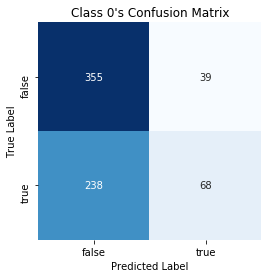

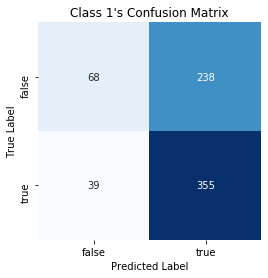

      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.604286  0.604286  0.604286  0.604286
1     presisi  0.635514  0.901015  0.604286  0.768265
2      recall  0.222222  0.901015  0.604286  0.561619
3  F1-measure  0.329298  0.901015  0.604286  0.615157


In [22]:
# evaluasi model tanpa smoothing
evaluation(y_test, y_predict_tanpaSmoothing, True)

#### Evaluasi model dengan smoothing

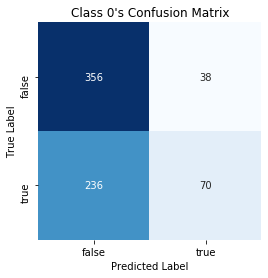

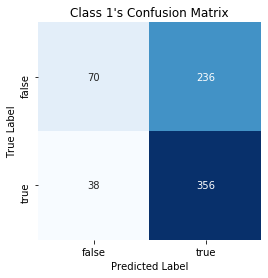

      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859


In [23]:
# evaluasi model dengan smoothing
evaluation(y_test, y_predict_denganSmoothing, True)

## 6. Analisis Hasil
### a) Perbandingan Model tanpa Smoothing dan Model dengan Smoothing
Jika dilihat metrik yang dihasilkan, angka yang dihasilkan oleh model dengan smoothing lebih tinggi daripada yang dihasilkan oleh model tanpa smoothing walaupun selisihnya tidak banyak. Hal ini menunjukkan bahwa smoothing memang dapat membantu masalah yang muncul seperti yang sebelumnya dijelaskan sebelum dilakukan implementasi fungsi estimasi.

Selisih yang tidak banyak ini bisa jadi karena data set yang digunakan tidak begitu membutuhkan smoothing. Di data set yang berbeda, bisa jadi, perbedaan antara model yang menggunakan smoothing dengan yang tidak menggunakan smoothing cukup besar dan signifikan.
### b) Perbedaan Rata-rata Mikro dan Makro
Secara teori, dan hal ini dapat dilihat di metriks yang dihasilkan, rata-rata mikro cenderung menyimpulkan performa model secara keseluruhan. Dapat dilihat bahwa semua metriks pada rata-rata mikro memiliki nilai yang sama. Artinya, secara keseluruhan, nilai tersebut adalah nilai yang didapatkan model yang digunakan.

Sementara itu, rata-rata makro lebih menunjukkan adanya perbedaan di metriks antar kelas. Nilai akurasi mikro dan makro sama besar, berarti akurasi kelas0 dan kelas1 sama. Nilai presisi dan F1-measure makro lebih besar daripada mikro dan nilai recall makro lebih kecil daripada mikro. Perbedaan ini menunjukkan bahwa terdapat perbedaan pula di metriks presisi, recall, dan F1-measure pada kelas0 dan kelas1. Perbedaan ini kemudian perlu dilihat lebih detail lagi di metriks setiap kelasnya untuk menganalisis performa modelnya.
### c) Preprocessing
Model yang telah terbentuk dibangun dari data yang tidak melalui tahap preprocessing. Di beberapa kasus, preprocessing dapat sangat membantu dalam meningkatkan performa model klasifikasi. Oleh karena itu, akan dicoba beberapa langkah preprocessing agar dapat meningkatkan performa model klasifikasi untuk kasus ini.

Untuk data teks, terdapat beberapa langkah yang dapat dilakukan di proses preprocessing, di antaranya:
1. Cleansing, membersihkan data dari tanda baca dan angka.
2. Casefolding, mengonversi semua huruf menjadi huruf kecil.
3. Stemming, mengubah semua kata menjadi kata dasar.
4. Stop words removal, menghapus semua stop words.

Kali ini, akan coba diterapkan keempat langkah tersebut dan akan dilihat pengaruhnya terhadap performa model. Pembuatan model yang digunakan adalah pembuatan model yang menggunakan smoothing.

#### Cleansing: Menghapus Angka

In [24]:
# menghapus angka

import re 

x_train_preprocess1 = []
x_test_preprocess1 = []

for i in range(len(x_train)):
    x_train_preprocess1.append(re.sub(r"\d+", "", x_train[i]))
    
for i in range(len(x_test)):
    x_test_preprocess1.append(re.sub(r"\d+", "", x_test[i]))

In [25]:
# pembuatan model
model_preprocess1 = training(x_train_preprocess1, y_train, 1000, True)

# testing
y_predict_preprocess1 = testing(x_test_preprocess1, model_preprocess1)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# evaluasi dengan preprocessing1
print('Evaluasi dengan preprocessing cleansing angka saja')
evaluation(y_test, y_predict_preprocess1, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing cleansing angka saja
      metriks    kelas0    kelas1  micro     macro
0     akurasi  0.620000  0.620000   0.62  0.620000
1     presisi  0.663934  0.895939   0.62  0.779937
2      recall  0.264706  0.895939   0.62  0.580322
3  F1-measure  0.378505  0.895939   0.62  0.637222


Ternyata, dengan menghilangkan angka, dapat diperoleh performa model yang lebih baik.

#### Cleansing: Menghapus Tanda Baca
Pertama-tama, akan dicoba preprocessing dengan menghapus tanda baca saja.

In [26]:
# menghilangkan tanda baca

import string

x_train_preprocess2 = []
x_test_preprocess2 = []

for i in range(len(x_train)):
    x_train_preprocess2.append(x_train[i].translate(str.maketrans("","",string.punctuation)))
    
for i in range(len(x_test)):
    x_test_preprocess2.append(x_test[i].translate(str.maketrans("","",string.punctuation)))

In [27]:
# pembuatan model
model_preprocess2 = training(x_train_preprocess2, y_train, 1000, True)

# testing
y_predict_preprocess2 = testing(x_test_preprocess2, model_preprocess2)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# evaluasi dengan preprocessing2
print('Evaluasi dengan preprocessing cleansing tanda baca saja')
evaluation(y_test, y_predict_preprocess2, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing cleansing tanda baca saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.631429  0.631429  0.631429  0.631429
1     presisi  0.684615  0.895939  0.631429  0.790277
2      recall  0.290850  0.895939  0.631429  0.593394
3  F1-measure  0.408257  0.895939  0.631429  0.652098


Ternyata, menghapus tanda baca membuat model memiliki performa yang lebih baik daripada menghapus angka. Selanjutnya, akan dicoba untuk melakukan penghapusan angka dan tanda baca sekaligus.

In [28]:
x_train_preprocess3 = []
x_test_preprocess3 = []

for i in range(len(x_train)):
    x_train_preprocess3.append(x_train_preprocess1[i].translate(str.maketrans("","",string.punctuation)))
    
for i in range(len(x_test)):
    x_test_preprocess3.append(x_test_preprocess1[i].translate(str.maketrans("","",string.punctuation)))

In [29]:
# pembuatan model
model_preprocess3 = training(x_train_preprocess3, y_train, 1000, True)

# testing
y_predict_preprocess3 = testing(x_test_preprocess3, model_preprocess3)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# menampilkan evaluasi dengan preprocessing1 untuk perbandingan
print('Evaluasi dengan preprocessing cleansing angka saja')
evaluation(y_test, y_predict_preprocess1, False)
print()

# menampilkan evaluasi dengan preprocessing2 untuk perbandingan
print('Evaluasi dengan preprocessing cleansing tanda baca saja')
evaluation(y_test, y_predict_preprocess2, False)
print()

# evaluasi dengan preprocessing3
print('Evaluasi dengan preprocessing cleansing angka dan tanda baca')
evaluation(y_test, y_predict_preprocess3, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing cleansing angka saja
      metriks    kelas0    kelas1  micro     macro
0     akurasi  0.620000  0.620000   0.62  0.620000
1     presisi  0.663934  0.895939   0.62  0.779937
2      recall  0.264706  0.895939   0.62  0.580322
3  F1-measure  0.378505  0.895939   0.62  0.637222

Evaluasi dengan preprocessing cleansing tanda baca saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.631429  0.631429  0.631429  0.631429
1     presisi  0.684615  0.895939  0.631429  0.790277
2      recall  0.290850  0.895939  0.631429  0.593394
3  F1-measure  0.408257  0.895939  0.631429  0.652098

Evaluasi dengan preprocessing cleansing angka dan tanda baca
     

Ternyata, menggabungkan keduanya tidak membuat model berperforma lebih baik daripada hanya menghapus tanda bacanya saja.

#### Case folding
Pertama-tama, akan dicoba preprocessing dengan hanya melakukan case folding.

In [30]:
# casefolding

x_train_preprocess4 = []
x_test_preprocess4 = []

for i in range(len(x_train)):
    x_train_preprocess4.append(x_train[i].lower())
    
for i in range(len(x_test)):
    x_test_preprocess4.append(x_test[i].lower())

In [31]:
# pembuatan model
model_preprocess4 = training(x_train_preprocess4, y_train, 1000, True)

# testing
y_predict_preprocess4 = testing(x_test_preprocess4, model_preprocess4)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# evaluasi dengan preprocessing4
print('Evaluasi dengan preprocessing case folding saja')
evaluation(y_test, y_predict_preprocess4, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing case folding saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.607143  0.607143  0.607143  0.607143
1     presisi  0.647619  0.906091  0.607143  0.776855
2      recall  0.222222  0.906091  0.607143  0.564157
3  F1-measure  0.330900  0.906091  0.607143  0.618496


Merubah huruf menjadi seluruhnya kecil ternyata tidak berpengaruh baik ke model klasifikasi walaupun hanya sedikit pengaruhnya.

#### Stemming
Pertama-tama akan dicoba untuk melakukan preprocessing dengan stemming saja.

In [32]:
# stemming

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
x_train_preprocess5 = []
x_test_preprocess5 = []

for i in range(len(x_train)):
    x_train_preprocess5.append(stemmer.stem(x_train[i]))
    
for i in range(len(x_test)):
    x_test_preprocess5.append(stemmer.stem(x_test[i]))

In [33]:
# pembuatan model
model_preprocess5 = training(x_train_preprocess5, y_train, 1000, True)

# testing
y_predict_preprocess5 = testing(x_test_preprocess5, model_preprocess5)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# evaluasi dengan preprocessing5
print('Evaluasi dengan preprocessing stemming saja')
evaluation(y_test, y_predict_preprocess5, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing stemming saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.612857  0.612857  0.612857  0.612857
1     presisi  0.642276  0.888325  0.612857  0.765301
2      recall  0.258170  0.888325  0.612857  0.573247
3  F1-measure  0.368298  0.888325  0.612857  0.628312


Angka-angka metrik setelah dilakukan stemming cenderung meningkat daripada yang tidak menggunakan stemming, namun tidak signifikan. Selanjutnya, akan dicoba untuk mengombinasikan stemming dengan penghapusan tanda baca yang sebelumnya berhasil dibuktikan membawa pengaruh baik ke performa model klasifikasi.

In [34]:
x_train_preprocess6 = []
x_test_preprocess6 = []

for i in range(len(x_train)):
    x_train_preprocess6.append(stemmer.stem(x_train_preprocess2[i]))
    
for i in range(len(x_test)):
    x_test_preprocess6.append(stemmer.stem(x_test_preprocess2[i]))

In [35]:
# pembuatan model
model_preprocess6 = training(x_train_preprocess6, y_train, 1000, True)

# testing
y_predict_preprocess6 = testing(x_test_preprocess6, model_preprocess6)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# menampilkan evaluasi dengan preprocessing2 untuk perbandingan
print('Evaluasi dengan preprocessing cleansing tanda baca saja')
evaluation(y_test, y_predict_preprocess2, False)
print()

# menampilkan evaluasi dengan preprocessing5 untuk perbandingan
print('Evaluasi dengan preprocessing stemming saja')
evaluation(y_test, y_predict_preprocess5, False)
print()

# evaluasi dengan preprocessing6
print('Evaluasi dengan preprocessing stemming dan cleansing tanda baca')
evaluation(y_test, y_predict_preprocess6, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing cleansing tanda baca saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.631429  0.631429  0.631429  0.631429
1     presisi  0.684615  0.895939  0.631429  0.790277
2      recall  0.290850  0.895939  0.631429  0.593394
3  F1-measure  0.408257  0.895939  0.631429  0.652098

Evaluasi dengan preprocessing stemming saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.612857  0.612857  0.612857  0.612857
1     presisi  0.642276  0.888325  0.612857  0.765301
2      recall  0.258170  0.888325  0.612857  0.573247
3  F1-measure  0.368298  0.888325  0.612857  0.628312

Evaluasi dengan preprocessing stemming dan cleansing tanda

Ternyata, dikombinasikan dengan penghapusan tanda baca, stemming malah tidak berpengaruh baik ke model klasifikasi. Kita bisa anggap stemming tidak efektif untuk diterapkan di preprocessing klasifikasi ini.

#### Stop words removal
Akan dicoba dulu untuk melakukan preprocessing dengan stop words removal saja.

In [36]:
# menghapus stop words

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
sw_remover = StopWordRemoverFactory().create_stop_word_remover()

x_train_preprocess7 = []
x_test_preprocess7 = []

for i in range(len(x_train)):
    x_train_preprocess7.append(sw_remover.remove(x_train[i]))
    
for i in range(len(x_test)):
    x_test_preprocess7.append(sw_remover.remove(x_test[i]))

In [37]:
# pembuatan model
model_preprocess7 = training(x_train_preprocess7, y_train, 1000, True)

# testing
y_predict_preprocess7 = testing(x_test_preprocess7, model_preprocess7)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# evaluasi dengan preprocessing
print('Evaluasi dengan preprocessing stop words removal saja')
evaluation(y_test, y_predict_preprocess7, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing stop words removal saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.645714  0.645714  0.645714  0.645714
1     presisi  0.723077  0.908629  0.645714  0.815853
2      recall  0.307190  0.908629  0.645714  0.607909
3  F1-measure  0.431193  0.908629  0.645714  0.669911


Stop words removal menunjukkan berpengaruh yang baik terhadap performa model klasifikasi. Selanjutnya, akan dicoba dikombinasikan dengan cleansing tanda baca yang sebelumnya sudah terbukti juga menaikkan performa model klasifikasi.

In [38]:
x_train_preprocess8 = []
x_test_preprocess8 = []

for i in range(len(x_train)):
    x_train_preprocess8.append(sw_remover.remove(x_train_preprocess2[i]))
    
for i in range(len(x_test)):
    x_test_preprocess8.append(sw_remover.remove(x_test_preprocess2[i]))

In [39]:
# pembuatan model
model_preprocess8 = training(x_train_preprocess8, y_train, 1000, True)

# testing
y_predict_preprocess8 = testing(x_test_preprocess8, model_preprocess8)

# menampilkan evaluasi tanpa preprocessing untuk perbandingan
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)
print()

# menampilkan evaluasi dengan preprocessing cleansing tanda baca untuk perbandingan
print('Evaluasi dengan preprocessing cleansing tanda baca saja')
evaluation(y_test, y_predict_preprocess2, False)
print()

# menampilkan evaluasi dengan preprocessing untuk perbandingan
print('Evaluasi dengan preprocessing stop words removal saja')
evaluation(y_test, y_predict_preprocess7, False)
print()

# evaluasi dengan preprocessing
print('Evaluasi dengan preprocessing cleansing tanda baca dan stop words removal')
evaluation(y_test, y_predict_preprocess8, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859

Evaluasi dengan preprocessing cleansing tanda baca saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.631429  0.631429  0.631429  0.631429
1     presisi  0.684615  0.895939  0.631429  0.790277
2      recall  0.290850  0.895939  0.631429  0.593394
3  F1-measure  0.408257  0.895939  0.631429  0.652098

Evaluasi dengan preprocessing stop words removal saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.645714  0.645714  0.645714  0.645714
1     presisi  0.723077  0.908629  0.645714  0.815853
2      recall  0.307190  0.908629  0.645714  0.607909
3  F1-measure  0.431193  0.908629  0.645714  0.669911

Evaluasi dengan preprocessing cleansing tanda ba

Mengombinasikan keduanya memang memberikan performa model klasifikasi yang lebih baik daripada hanya melakukan cleansing tanda baca. Namun, dibandingkan dengan preprocessing yang hanya menghilangkan stop words, kombinasi kedua preprocessing ini tidak lebih baik. Dengan begitu, dapat disimpulkan bahwa preprocessing terbaik adalah dengan menghilangkan stop words saja.

#### Kesimpulan
Performa model dapat lebih baik dihasilkan jika data terlebih dahulu melalui proses preprocessing. Di antara beberapa proses preprocessing yang mungkin diterapkan di data teks, proses preprocessing yang paling efektif diterapkan di data dan permasalahan ini adalah stop words removal. Tanpa preprocessing, perfoma model yang dihasilkan adalah sebagai berikut:

In [40]:
# evaluasi tanpa preprocessing
print('Evaluasi tanpa preprocessing')
evaluation(y_test, y_predict_denganSmoothing, False)

Evaluasi tanpa preprocessing
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.608571  0.608571  0.608571  0.608571
1     presisi  0.648148  0.903553  0.608571  0.775851
2      recall  0.228758  0.903553  0.608571  0.566156
3  F1-measure  0.338164  0.903553  0.608571  0.620859


Sedangkan, dengan stop words removal, dihasilkan performa model sebagai berikut:

In [41]:
print('Evaluasi dengan preprocessing stop words removal saja')
evaluation(y_test, y_predict_preprocess7, False)

Evaluasi dengan preprocessing stop words removal saja
      metriks    kelas0    kelas1     micro     macro
0     akurasi  0.645714  0.645714  0.645714  0.645714
1     presisi  0.723077  0.908629  0.645714  0.815853
2      recall  0.307190  0.908629  0.645714  0.607909
3  F1-measure  0.431193  0.908629  0.645714  0.669911
